# Лабораторная 2. RNN
### Предсказываем Close для PayPal

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is selected.")

cuda is selected.


In [2]:
df = pd.read_csv("PayPal.csv")

In [3]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-06,38.000000,39.750000,36.000000,36.709999,36.709999,5866600
1,2015-07-07,37.720001,37.810001,36.000000,36.619999,36.619999,7359000
2,2015-07-08,36.340000,36.360001,34.529999,34.700001,34.700001,5387700
3,2015-07-09,35.099998,35.520000,33.990002,34.500000,34.500000,3760100
4,2015-07-10,34.660000,35.189999,33.980000,34.689999,34.689999,4472800
...,...,...,...,...,...,...,...
1729,2022-05-16,78.589996,79.059998,76.188004,77.650002,77.650002,15432300
1730,2022-05-17,79.889999,81.285004,77.309998,79.750000,79.750000,12677400
1731,2022-05-18,78.599998,79.938004,76.769997,77.180000,77.180000,15955300
1732,2022-05-19,76.830002,82.309998,76.830002,81.279999,81.279999,19779300


<AxesSubplot: >

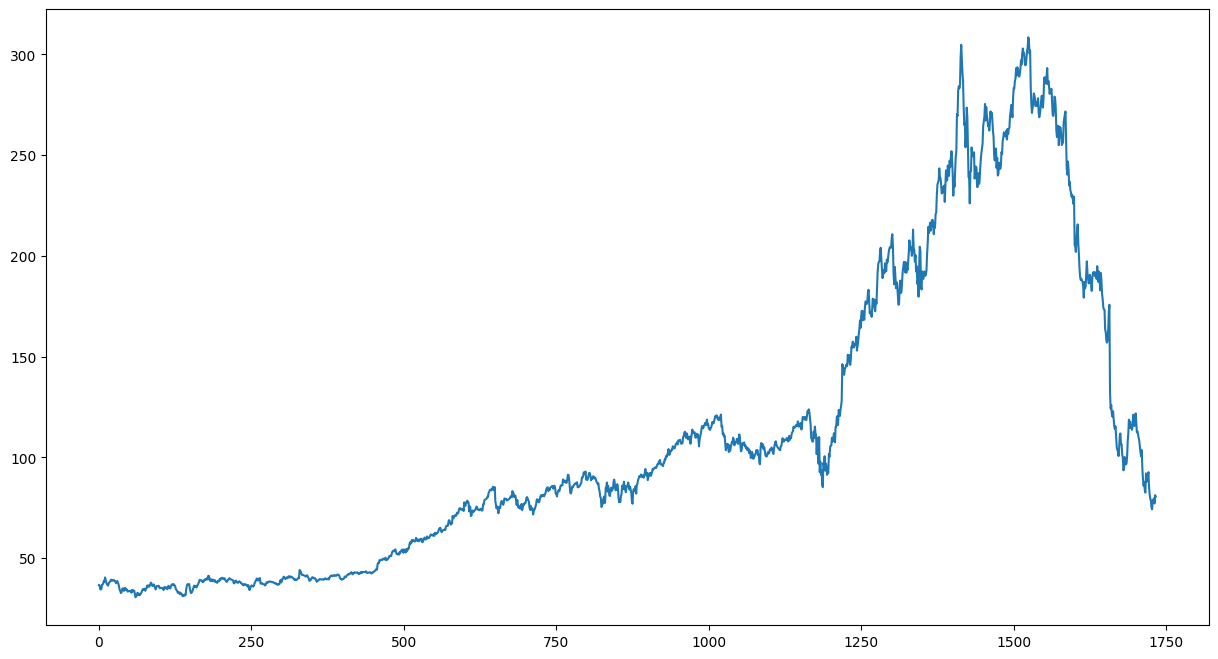

In [4]:
df["Close"].plot(figsize = (15, 8))

In [5]:
years = []
months = []
days = []
dates = []

pd.options.mode.chained_assignment = None
for i in range(len(df)):
    time = df["Date"][i].split("-")
    year = int(time[0])
    month = int(time[1])
    day = int(time[2])
    date = f"{year}-{month:02d}-{day:02d}"
    dates.append(date)

#df = df.drop(["Adj Close", "Volume", "Date"], axis=1)
df = df.loc[:, ["Close"]]

In [6]:
WINDOW_SIZE = 4 # по прошлым N дням будем гадать следующий

df["TargetClose"] = df["Close"].shift(-WINDOW_SIZE)
df = df.dropna()
df

,Close,TargetClose
0,36.709999,34.689999
1,36.619999,36.779999
2,34.700001,36.930000
3,34.500000,37.509998
4,34.689999,38.630001
...,...,...
1725,78.750000,77.650002
1726,75.169998,79.750000
1727,74.290001,77.180000
1728,78.830002,81.279999


In [7]:
from sklearn.model_selection import train_test_split

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, Y_train, Y_val, Y_test = train_val_test_split(df, 'TargetClose', 0.3)

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('minmax')
X_train_arr = scaler.fit_transform(X_train)
X_test_arr = scaler.transform(X_test)
X_val_arr = scaler.transform(X_val)

Y_train_arr = scaler.fit_transform(Y_train)
Y_test_arr = scaler.transform(Y_test)
Y_val_arr = scaler.transform(Y_val)

## DataLoaders

In [9]:
from torch.utils.data import DataLoader, TensorDataset

BATCH_SIZE = 64

ds_x_train = torch.Tensor(X_train_arr)
ds_y_train = torch.Tensor(Y_train_arr)
tds_train = TensorDataset(ds_x_train, ds_y_train)
train_loader = DataLoader(tds_train, batch_size=BATCH_SIZE, shuffle=False)

ds_x_test = torch.Tensor(X_test_arr)
ds_y_test = torch.Tensor(Y_test_arr)
tds_test = TensorDataset(ds_x_test, ds_y_test)
test_loader = DataLoader(tds_test, batch_size=BATCH_SIZE, shuffle=False)

ds_x_val = torch.Tensor(X_val_arr)
ds_y_val = torch.Tensor(Y_val_arr)
tds_val = TensorDataset(ds_x_val, ds_y_val)
valid_loader = DataLoader(tds_val, batch_size=BATCH_SIZE, shuffle=False)

## Архитектуры

In [10]:
from torch import nn

models = list()

class Net1(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNN(
            input_size=input_size, hidden_size=hidden_size, 
            num_layers=num_layers, batch_first=True)
        self.lin = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        x, _ = self.rnn(x, h0.detach())
        #x, _ = self.rnn(x)
        x = self.lin(x)
        return x
    
net1 = Net1(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=128, num_layers=1)

models.append(net1)

In [11]:
#LSTM inside!
class Net2_LSTM(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True)
        self.lin = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        x, _ = self.lstm(x, (h0.detach(), c0.detach()))
        x = self.lin(x)
        return x
    
net2 = Net2_LSTM(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=64, num_layers=1)

models.append(net2)

In [12]:
#Simple GRU
class Net3_GRU(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, batch_first=True)
        self.lin = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_size).requires_grad_().to(device)
        
        x, _ = self.gru(x, h0.detach())
        x = self.lin(x)
        return x
    
net3 = Net3_GRU(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=128, num_layers=1)

models.append(net3)

In [13]:
class Net4_GRUS(nn.Module):
    def __init__(self, input_size, out_size, hidden_size, num_layers):
        super(self.__class__, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.grus = nn.ModuleList()
        
        self.grus.append(nn.GRU(
                input_size, hidden_size, 1, batch_first=True))
        
        for i in range(num_layers-1):
            self.grus.append(nn.GRU(
                hidden_size, hidden_size, 1, batch_first=True))
            
        self.lin = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        hs = [torch.zeros(1, self.hidden_size).requires_grad_().to(device)]
        for i in range(self.num_layers):
            #print(x.shape, hs[-1].shape)
            out, hs_out = self.grus[i](x, hs[-1])
            #print("out", out.shape, hs_out.shape)
            x = out
            hs.append(hs_out)

        #print(x.shape, h_n.shape)
        x = self.lin(x)
        return x
    
net4 = Net4_GRUS(
    input_size=len(X_train.columns), out_size=1, 
    hidden_size=128, num_layers=2)

models.append(net4)

## Обучение

In [14]:
import matplotlib.pyplot as plt
from datetime import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"

class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train

        """
        model_path = f'{self.model.__class__.__name__}_{datetime.now().strftime("%Y-%m-%d %H_%M_%S")}'
        best_model_state = None
        best_losses = None

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)

                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)
                
            if best_losses is None:
                best_losses = [training_loss, validation_loss, epoch]
                best_model_state = self.model.state_dict()
            elif training_loss < best_losses[0] and validation_loss < best_losses[1]:
                best_losses = [training_loss, validation_loss, epoch]
                best_model_state = self.model.state_dict()
            elif training_loss < best_losses[0]/2 and validation_loss < best_losses[1]*1.25:
                best_losses = [training_loss, validation_loss, epoch]
                best_model_state = self.model.state_dict()
            elif training_loss < best_losses[0]*1.25 and validation_loss < best_losses[1]:
                best_losses = [training_loss, validation_loss, epoch]
                best_model_state = self.model.state_dict()

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
        
        training_loss, validation_loss, epoch = best_losses[0], best_losses[1], best_losses[2]
        self.best_epoch = epoch
        print(f"\tBest epoch: {epoch}")
        print(f"Best train loss: {training_loss}, best valid loss: {validation_loss}")
        torch.save(best_model_state, model_path)

    def evaluate(self, test_loader, batch_size=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.cpu().detach().numpy())
                values.append(y_test.cpu().detach().numpy())

        return predictions, values

    def plot_losses(self, zoom_len: int = 50):
        """The method plots the calculated loss values for training and validation
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.axvline(x = self.best_epoch, color = 'b', label = 'Best epoch', ls='--')
        plt.legend()
        plt.title(f"Losses for {self.model.__class__.__name__}")
        plt.show()
        
        left_border = min(len(self.val_losses), self.best_epoch - zoom_len)
        right_border = min(len(self.val_losses), self.best_epoch + zoom_len)
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.axvline(x = self.best_epoch-1, color = 'b', label = 'Best epoch', ls='--')
        plt.legend()
        plt.title(f"Losses for {self.model.__class__.__name__}. Zoom: {zoom_len}")
        plt.xlim([left_border, right_border])
        plt.show()
        plt.close()

[1/400] Training loss: 0.0291	 Validation loss: 1.0062
[2/400] Training loss: 0.1770	 Validation loss: 1.9853
[3/400] Training loss: 0.0524	 Validation loss: 0.7801
[4/400] Training loss: 0.0854	 Validation loss: 0.7373
[5/400] Training loss: 0.0173	 Validation loss: 0.1744
[6/400] Training loss: 0.0108	 Validation loss: 0.2070
[7/400] Training loss: 0.0182	 Validation loss: 0.0837
[8/400] Training loss: 0.0145	 Validation loss: 0.2235
[9/400] Training loss: 0.0219	 Validation loss: 0.1048
[10/400] Training loss: 0.0102	 Validation loss: 0.1080
[50/400] Training loss: 0.0014	 Validation loss: 0.0574
[100/400] Training loss: 0.0010	 Validation loss: 0.0219
[150/400] Training loss: 0.0034	 Validation loss: 0.0153
[200/400] Training loss: 0.0015	 Validation loss: 0.0404
[250/400] Training loss: 0.0013	 Validation loss: 0.0339
[300/400] Training loss: 0.0015	 Validation loss: 0.0486
[350/400] Training loss: 0.0010	 Validation loss: 0.0514
[400/400] Training loss: 0.0016	 Validation loss: 0

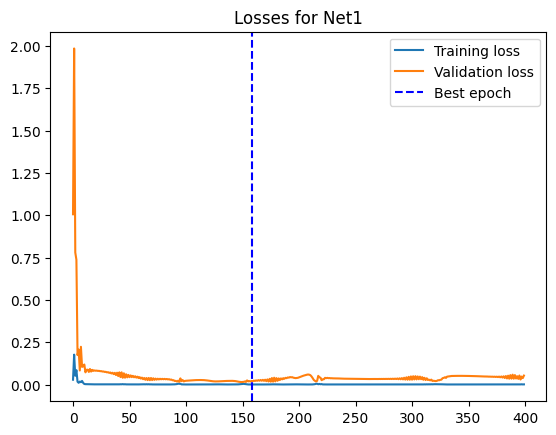

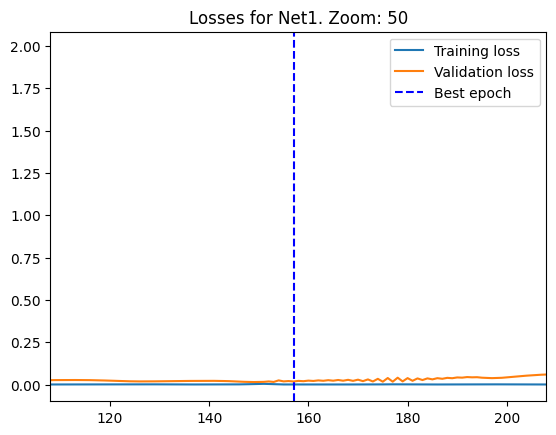

[1/400] Training loss: 0.1128	 Validation loss: 1.8109
[2/400] Training loss: 0.0694	 Validation loss: 1.1433
[3/400] Training loss: 0.0711	 Validation loss: 0.8663
[4/400] Training loss: 0.0438	 Validation loss: 0.3746
[5/400] Training loss: 0.0324	 Validation loss: 0.2913
[6/400] Training loss: 0.0205	 Validation loss: 0.3429
[7/400] Training loss: 0.0309	 Validation loss: 0.3506
[8/400] Training loss: 0.0209	 Validation loss: 0.2827
[9/400] Training loss: 0.0129	 Validation loss: 0.2245
[10/400] Training loss: 0.0104	 Validation loss: 0.2188
[50/400] Training loss: 0.0027	 Validation loss: 0.1032
[100/400] Training loss: 0.0013	 Validation loss: 0.0503
[150/400] Training loss: 0.0010	 Validation loss: 0.0286
[200/400] Training loss: 0.0010	 Validation loss: 0.0327
[250/400] Training loss: 0.0009	 Validation loss: 0.0416
[300/400] Training loss: 0.0009	 Validation loss: 0.0435
[350/400] Training loss: 0.0028	 Validation loss: 0.0859
[400/400] Training loss: 0.0009	 Validation loss: 0

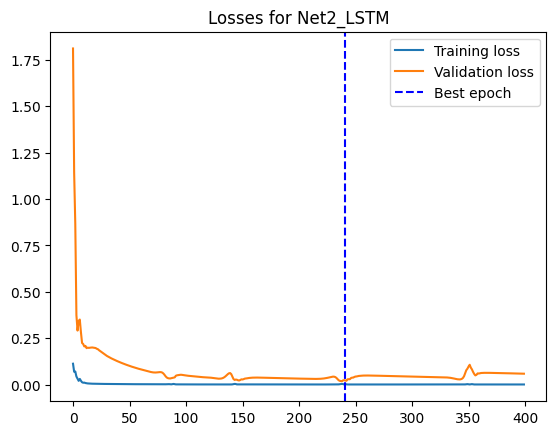

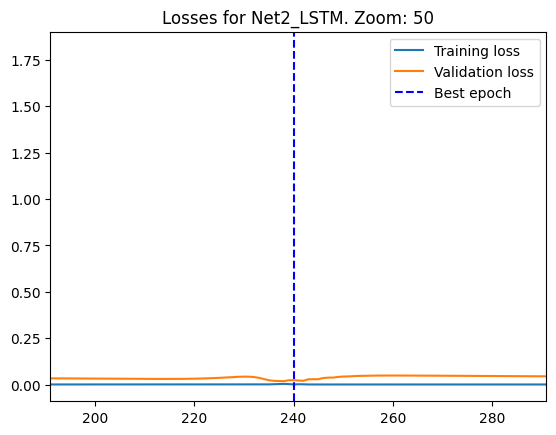

[1/400] Training loss: 0.0444	 Validation loss: 0.6536
[2/400] Training loss: 0.1470	 Validation loss: 1.2946
[3/400] Training loss: 0.0416	 Validation loss: 0.6439
[4/400] Training loss: 0.0298	 Validation loss: 0.2134
[5/400] Training loss: 0.0116	 Validation loss: 0.1190
[6/400] Training loss: 0.0080	 Validation loss: 0.1224
[7/400] Training loss: 0.0105	 Validation loss: 0.0965
[8/400] Training loss: 0.0057	 Validation loss: 0.0871
[9/400] Training loss: 0.0049	 Validation loss: 0.0839
[10/400] Training loss: 0.0054	 Validation loss: 0.0822
[50/400] Training loss: 0.0015	 Validation loss: 0.0330
[100/400] Training loss: 0.0011	 Validation loss: 0.0189
[150/400] Training loss: 0.0011	 Validation loss: 0.0166
[200/400] Training loss: 0.0016	 Validation loss: 0.0294
[250/400] Training loss: 0.0011	 Validation loss: 0.0287
[300/400] Training loss: 0.0014	 Validation loss: 0.0165
[350/400] Training loss: 0.0009	 Validation loss: 0.0178
[400/400] Training loss: 0.0009	 Validation loss: 0

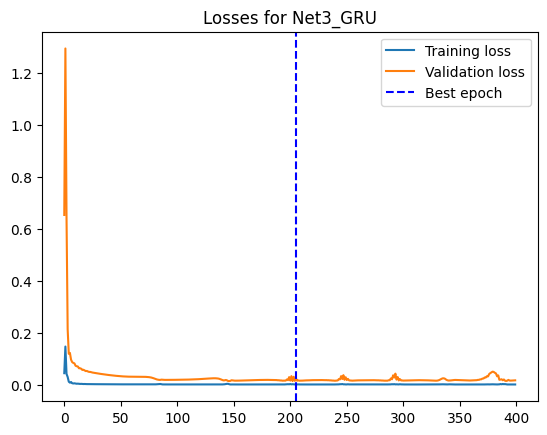

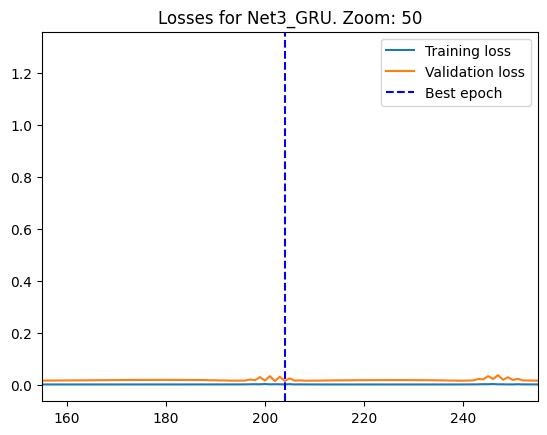

[1/400] Training loss: 0.0199	 Validation loss: 1.1771
[2/400] Training loss: 0.2117	 Validation loss: 2.0210
[3/400] Training loss: 0.0332	 Validation loss: 0.2831
[4/400] Training loss: 0.0433	 Validation loss: 0.1372
[5/400] Training loss: 0.0147	 Validation loss: 0.1615
[6/400] Training loss: 0.0218	 Validation loss: 0.0812
[7/400] Training loss: 0.0055	 Validation loss: 0.0747
[8/400] Training loss: 0.0047	 Validation loss: 0.0655
[9/400] Training loss: 0.0039	 Validation loss: 0.0576
[10/400] Training loss: 0.0025	 Validation loss: 0.0546
[50/400] Training loss: 0.0011	 Validation loss: 0.0322
[100/400] Training loss: 0.0018	 Validation loss: 0.0463
[150/400] Training loss: 0.0009	 Validation loss: 0.0347
[200/400] Training loss: 0.0016	 Validation loss: 0.0696
[250/400] Training loss: 0.0012	 Validation loss: 0.0671
[300/400] Training loss: 0.0015	 Validation loss: 0.0495
[350/400] Training loss: 0.0010	 Validation loss: 0.0554
[400/400] Training loss: 0.0045	 Validation loss: 0

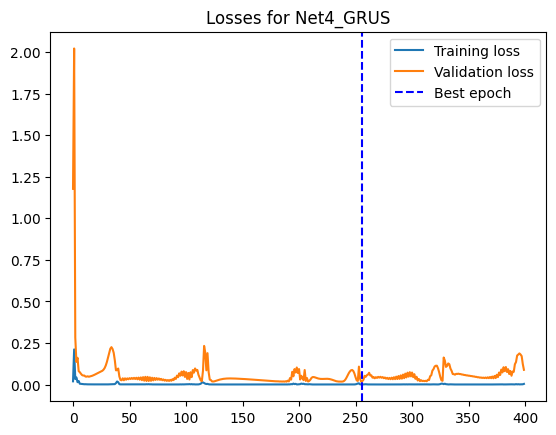

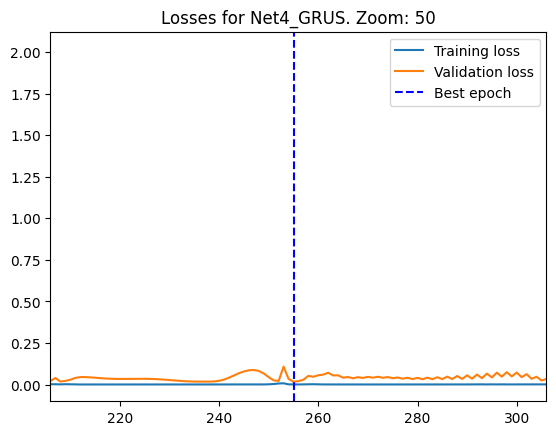

In [15]:
import torch.optim as optim

N_EPOCHS = 400
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 2e-5

optimizers = list()
loss_fn = nn.MSELoss(reduction="mean")
#loss_fn = nn.L1Loss(reduction="mean") #MAE

for model in models:
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    optimizers.append(opt)

for opt in optimizers:
    opt.train(train_loader, valid_loader, batch_size=BATCH_SIZE, n_epochs=N_EPOCHS)
    opt.plot_losses(50)

### Даты надо человеческие для предикта

In [16]:
test_dates = dates[len(X_train)+len(X_val):]
label_dates = []
    
for i in range(len(test_dates)):
    if i % 100 > 0:
        continue
    date = test_dates[i]
    label_dates.append(date)

### Смотрим, что предсказала модель, а что должно быть

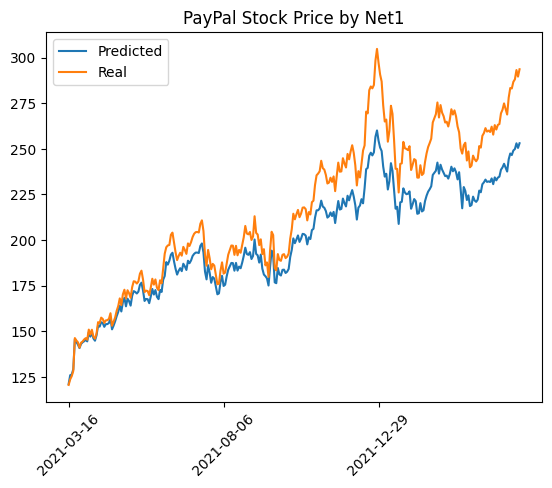

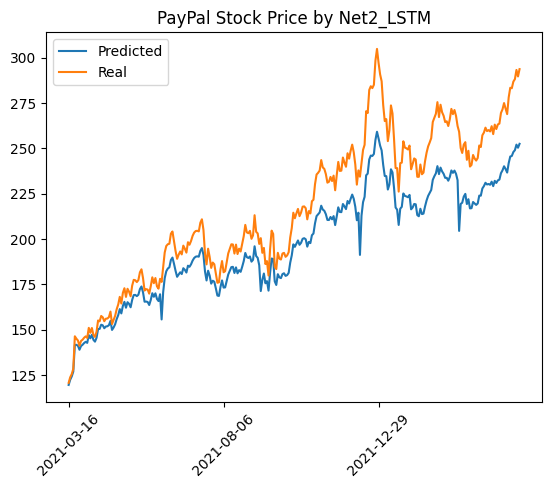

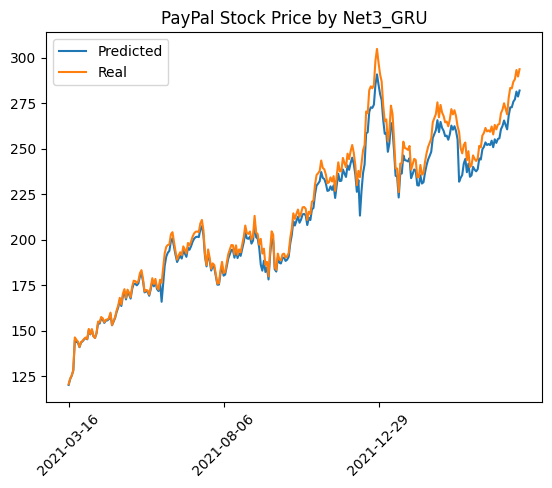

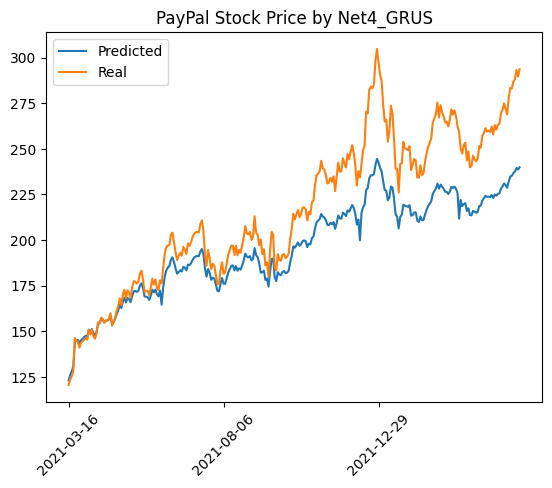

In [17]:
models_values = []

for opt in optimizers:
    predictions, values = opt.evaluate(test_loader, BATCH_SIZE)
    vals = np.array([])
    preds = np.array([])
    for pred, value in zip(predictions, values):
        vals = np.append(vals, value)
        preds = np.append(preds, pred)
        
    vals = scaler.inverse_transform(vals.reshape(-1, 1))
    preds = scaler.inverse_transform(preds.reshape(-1, 1))

    plt.plot(preds, label="Predicted")
    plt.plot(vals, label="Real")
    plt.legend()
    plt.title(f"PayPal Stock Price by {opt.model.__class__.__name__}")
    plt.xticks([i*100 for i in range(len(label_dates))], label_dates, rotation=45)
    plt.show()
    plt.close()
    models_values.append([opt.model.__class__.__name__, preds, vals])

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(preds, real):
    result_metrics = {'mae' : mean_absolute_error(real, preds),
                      'rmse' : mean_squared_error(real, preds) ** 0.5,
                      'r2' : r2_score(real, preds)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

for values in models_values:
    name = values[0]
    preds = values[1]
    real = values[2]
    print("\t", name)
    calculate_metrics(preds, real)

	 Net1
Mean Absolute Error:        18.634906559916924
Root Mean Squared Error:    22.894200691611704
R^2 Score:                  0.7047401508300232
	 Net2_LSTM
Mean Absolute Error:        21.02907698776008
Root Mean Squared Error:    25.261347259950366
R^2 Score:                  0.6405268639426211
	 Net3_GRU
Mean Absolute Error:        10.229399541312802
Root Mean Squared Error:    13.223567313006047
R^2 Score:                  0.901496722038684
	 Net4_GRUS
Mean Absolute Error:        22.364684144289367
Root Mean Squared Error:    27.971662978553997
R^2 Score:                  0.5592523591920544
